In [ ]:
# Cell 1: Full Setup, Imports, and Helper Function Definitions

# --- Basic Imports and Setup ---
import os
import json
import pickle
import pandas as pd
import numpy as np
import torch
from torch import nn
from google.colab import drive

# --- Scikit-learn and MLxtend Imports ---
from sklearn.model_selection import StratifiedKFold
from mlxtend.evaluate import mcnemar_table, mcnemar

# --- Hugging Face Transformers Imports ---
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    BertPreTrainedModel,
    BertModel
)
from transformers.modeling_outputs import SequenceClassifierOutput

# --- Mount Google Drive ---
drive.mount('/content/drive')

# --- KEY SETTINGS ---
GDRIVE_PATH = '/content/drive/MyDrive/eecsi_revise/'
SEED = 42
TEXT_COLUMN = 'cleaned_text'

# --- Custom Class Definitions (Required to load models) ---
class IndoBERT_MTL(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.aspect_classifier = nn.Linear(config.hidden_size, config.num_aspect_labels)
        self.sentiment_classifier = nn.Linear(config.hidden_size, config.num_sentiment_labels)
        self.init_weights()
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, aspect_labels=None, sentiment_labels=None, return_dict=None, **kwargs):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=return_dict)
        pooled_output = outputs[1]; pooled_output = self.dropout(pooled_output)
        aspect_logits = self.aspect_classifier(pooled_output); sentiment_logits = self.sentiment_classifier(pooled_output)
        # Handle prediction case where no labels are passed
        if aspect_labels is None:
            return SequenceClassifierOutput(loss=None, logits=(aspect_logits, sentiment_logits), hidden_states=outputs.hidden_states, attentions=outputs.attentions)
        # Handle training case
        else:
            total_loss = 0; loss_fct = nn.CrossEntropyLoss()
            total_loss += loss_fct(aspect_logits.view(-1, self.config.num_aspect_labels), aspect_labels.view(-1))
            total_loss += loss_fct(sentiment_logits.view(-1, self.config.num_sentiment_labels), sentiment_labels.view(-1))
            return SequenceClassifierOutput(loss=total_loss, logits=(aspect_logits, sentiment_logits), hidden_states=outputs.hidden_states, attentions=outputs.attentions)

class PredictionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings): self.encodings = encodings
    def __getitem__(self, idx): return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self): return len(self.encodings.input_ids)

# --- Helper Function to Find Best Checkpoint ---
def find_best_checkpoint(fold_dir):
    try:
        if not os.path.exists(fold_dir): raise FileNotFoundError(f"Directory not found: {fold_dir}")
        possible_checkpoints = [d for d in os.listdir(fold_dir) if d.startswith('checkpoint-') and os.path.isdir(os.path.join(fold_dir, d))]
        if not possible_checkpoints: raise FileNotFoundError(f"No checkpoint folders found inside {fold_dir}")
        latest_checkpoint_dir = sorted(possible_checkpoints, key=lambda x: int(x.split('-')[-1]))[-1]
        state_path = os.path.join(fold_dir, latest_checkpoint_dir, 'trainer_state.json')
        with open(state_path, 'r') as f: state = json.load(f)
        best_checkpoint_name = os.path.basename(state['best_model_checkpoint'])
        best_checkpoint_path = os.path.join(fold_dir, best_checkpoint_name)
        print(f"  ✅ Best model confirmed: {best_checkpoint_name}")
        return best_checkpoint_path
    except Exception as e:
        print(f"  ❌ ERROR: Could not determine best model for {fold_dir}. Reason: {e}. Skipping fold.")
        return None

print("✅ Setup complete. All libraries, classes, and helper functions are ready.")

Mounted at /content/drive
✅ Setup complete. All libraries, classes, and helper functions are ready.


In [ ]:
# Cell 2: Generate or Load All ASC Predictions

asc_predictions_path = os.path.join(GDRIVE_PATH, 'all_asc_predictions.pkl')

if os.path.exists(asc_predictions_path):
    print(f"--- Loading existing ASC predictions from file ---")
    with open(asc_predictions_path, 'rb') as f:
        all_asc_predictions = pickle.load(f)
    print("✅ ASC Predictions loaded successfully.")
else:
    print(f"--- Generating ASC predictions as file was not found. This may take a few minutes... ---")

    # --- 1. Load Data and Filter for Relevant Tweets ---
    df = pd.read_csv(os.path.join(GDRIVE_PATH, 'final_golden_dataset_eecsi.csv'))
    relevant_df = df[df['aspect'] != 'Irrelevant'].copy()
    print(f"Found {len(relevant_df)} relevant tweets for ASC analysis.")

    # --- 2. Setup (Labels, etc.) ---
    sentiment_labels_list = sorted(relevant_df['sentiment'].unique())
    s_label2id = {l: i for i, l in enumerate(sentiment_labels_list)}
    s_id2label = {i: l for i, l in enumerate(sentiment_labels_list)}

    # --- 3. Prediction Function for PIPELINE Models ---
    def get_pipeline_asc_predictions(model_id, results_path):
        print(f"\n--- Processing PIPELINE model: {os.path.basename(os.path.normpath(results_path))} ---")
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        model_preds = pd.Series([None] * len(relevant_df), index=relevant_df.index)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        for i, (train_index, test_index) in enumerate(skf.split(relevant_df, relevant_df['sentiment'])):
            fold_num = i + 1; print(f"  Processing Fold {fold_num}/5...")
            fold_dir = os.path.join(results_path, f'fold_{fold_num}')
            if not os.path.exists(fold_dir): fold_dir = os.path.join(results_path, f'results_fold_{fold_num}')
            best_checkpoint_path = find_best_checkpoint(fold_dir)
            if not best_checkpoint_path: continue
            model = AutoModelForSequenceClassification.from_pretrained(best_checkpoint_path)
            trainer = Trainer(model=model)
            test_data = relevant_df.iloc[test_index]
            test_encodings = tokenizer(list(test_data[TEXT_COLUMN]), truncation=True, padding=True, max_length=128)
            prediction_dataset = PredictionDataset(test_encodings)
            predictions = trainer.predict(prediction_dataset)
            predicted_labels_int = np.argmax(predictions.predictions, axis=1)
            model_preds.iloc[test_index] = predicted_labels_int
        return model_preds.map(s_id2label)

    # --- 4. Prediction Function for MTL Models ---
    def get_mtl_asc_predictions(model_id, results_path):
        print(f"\n--- Processing MTL model: {os.path.basename(os.path.normpath(results_path))} ---")
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        model_preds = pd.Series([None] * len(relevant_df), index=relevant_df.index)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        for i, (train_index, test_index) in enumerate(skf.split(relevant_df, relevant_df['sentiment'])):
            fold_num = i + 1; print(f"  Processing Fold {fold_num}/5...")
            fold_dir = os.path.join(results_path, f'fold_{fold_num}')
            if not os.path.exists(fold_dir): fold_dir = os.path.join(results_path, f'results_fold_{fold_num}')
            best_checkpoint_path = find_best_checkpoint(fold_dir)
            if not best_checkpoint_path: continue
            model = IndoBERT_MTL.from_pretrained(best_checkpoint_path)
            trainer = Trainer(model=model)
            test_data = relevant_df.iloc[test_index]
            test_encodings = tokenizer(list(test_data[TEXT_COLUMN]), truncation=True, padding=True, max_length=128)
            prediction_dataset = PredictionDataset(test_encodings)
            predictions = trainer.predict(prediction_dataset)
            sentiment_logits = predictions.predictions[1] # Take the second output for sentiment
            predicted_labels_int = np.argmax(sentiment_logits, axis=1)
            model_preds.iloc[test_index] = predicted_labels_int
        return model_preds.map(s_id2label)

    # --- 5. Generate Predictions for ALL Key Models ---
    all_asc_predictions = {
        'y_true_sentiment': relevant_df['sentiment'],
        'indobertweet_pipeline_asc': get_pipeline_asc_predictions("indolem/indobertweet-base-uncased", os.path.join(GDRIVE_PATH, 'indobertweet_asc_results/')),
        'indobert_pipeline_asc': get_pipeline_asc_predictions("indobenchmark/indobert-base-p1", os.path.join(GDRIVE_PATH, 'indobert_asc_results/')),
        'mtl_indobert_asc': get_mtl_asc_predictions("indobenchmark/indobert-base-p1", os.path.join(GDRIVE_PATH, 'mtl_indobert_results/')),
        'mtl_indobertweet_asc': get_mtl_asc_predictions("indolem/indobertweet-base-uncased", os.path.join(GDRIVE_PATH, 'mtl_indobertweet_results/'))
    }

    with open(asc_predictions_path, 'wb') as f:
        pickle.dump(all_asc_predictions, f)
    print(f"\n✅ All ASC raw predictions have been generated and saved to: {asc_predictions_path}")

--- Generating ASC predictions as file was not found. This may take a few minutes... ---
Found 2037 relevant tweets for ASC analysis.

--- Processing PIPELINE model: indobertweet_asc_results ---
  Processing Fold 1/5...
  ✅ Best model confirmed: checkpoint-411


  Processing Fold 2/5...
  ✅ Best model confirmed: checkpoint-685


  Processing Fold 3/5...
  ✅ Best model confirmed: checkpoint-274


  Processing Fold 4/5...
  ✅ Best model confirmed: checkpoint-685


  Processing Fold 5/5...
  ✅ Best model confirmed: checkpoint-685



--- Processing PIPELINE model: indobert_asc_results ---
  Processing Fold 1/5...
  ✅ Best model confirmed: checkpoint-685


  Processing Fold 2/5...
  ✅ Best model confirmed: checkpoint-685


  Processing Fold 3/5...
  ✅ Best model confirmed: checkpoint-685


  Processing Fold 4/5...
  ✅ Best model confirmed: checkpoint-548


  Processing Fold 5/5...
  ✅ Best model confirmed: checkpoint-137



--- Processing MTL model: mtl_indobert_results ---
  Processing Fold 1/5...
  ✅ Best model confirmed: checkpoint-510


  Processing Fold 2/5...
  ✅ Best model confirmed: checkpoint-408


  Processing Fold 3/5...
  ✅ Best model confirmed: checkpoint-408


  Processing Fold 4/5...
  ✅ Best model confirmed: checkpoint-408


  Processing Fold 5/5...
  ✅ Best model confirmed: checkpoint-408



--- Processing MTL model: mtl_indobertweet_results ---
  Processing Fold 1/5...
  ✅ Best model confirmed: checkpoint-408


  Processing Fold 2/5...
  ✅ Best model confirmed: checkpoint-408


  Processing Fold 3/5...
  ✅ Best model confirmed: checkpoint-510


  Processing Fold 4/5...
  ✅ Best model confirmed: checkpoint-510


  Processing Fold 5/5...
  ✅ Best model confirmed: checkpoint-408



✅ All ASC raw predictions have been generated and saved to: /content/drive/MyDrive/eecsi_revise/all_asc_predictions.pkl


In [ ]:
# Cell 3: Run McNemar's Test for Final Justification

print("\n--- McNemar's Test for Aspect Sentiment Classification (ASC) ---")
print("Goal: To justify the selection of the Pipeline architecture over the MTL architecture.")
print("Comparing: IndoBERTweet Pipeline (Champion) vs. IndoBERT MTL (Competitor) on RELEVANT data.")

# Load the comprehensive ASC predictions you just generated
with open(asc_predictions_path, 'rb') as f:
    all_asc_predictions = pickle.load(f)

# --- CORRECTED MODEL SELECTION FOR COMPARISON ---
# Prepare the data for the comparison you actually want to make
y_true = np.array(all_asc_predictions['y_true_sentiment'])
y_model1 = np.array(all_asc_predictions['indobertweet_pipeline_asc']) # Your Pipeline Champion
y_model2 = np.array(all_asc_predictions['mtl_indobert_asc'])         # The MTL Champion Competitor

# Ensure there are no missing values which can cause errors
valid_indices = pd.Series(y_true).notna() & pd.Series(y_model1).notna() & pd.Series(y_model2).notna()
y_true = y_true[valid_indices]
y_model1 = y_model1[valid_indices]
y_model2 = y_model2[valid_indices]


# Create the contingency table
tb = mcnemar_table(y_target=y_true, y_model1=y_model1, y_model2=y_model2)
print("\nContingency Table (Model 1 = IndoBERTweet Pipeline, Model 2 = IndoBERT MTL):")
print(tb)

# Perform McNemar's test
chi2, p = mcnemar(ary=tb, corrected=True)
print(f"\nMcNemar's test results:")
print(f"  Chi-squared statistic: {chi2:.4f}")
print(f"  p-value: {p:.4f}")

# Interpret the result
alpha = 0.05
if p > alpha:
    print("\nConclusion: The performance difference between the Pipeline and MTL architectures for ASC is NOT statistically significant.")
else:
    print("\nConclusion: The performance difference between the Pipeline and MTL architectures for ASC IS statistically significant.")


--- McNemar's Test for Aspect Sentiment Classification (ASC) ---
Goal: To justify the selection of the Pipeline architecture over the MTL architecture.
Comparing: IndoBERTweet Pipeline (Champion) vs. IndoBERT MTL (Competitor) on RELEVANT data.

Contingency Table (Model 1 = IndoBERTweet Pipeline, Model 2 = IndoBERT MTL):
[[1672   34]
 [ 275   56]]

McNemar's test results:
  Chi-squared statistic: 186.4078
  p-value: 0.0000

Conclusion: The performance difference between the Pipeline and MTL architectures for ASC IS statistically significant.


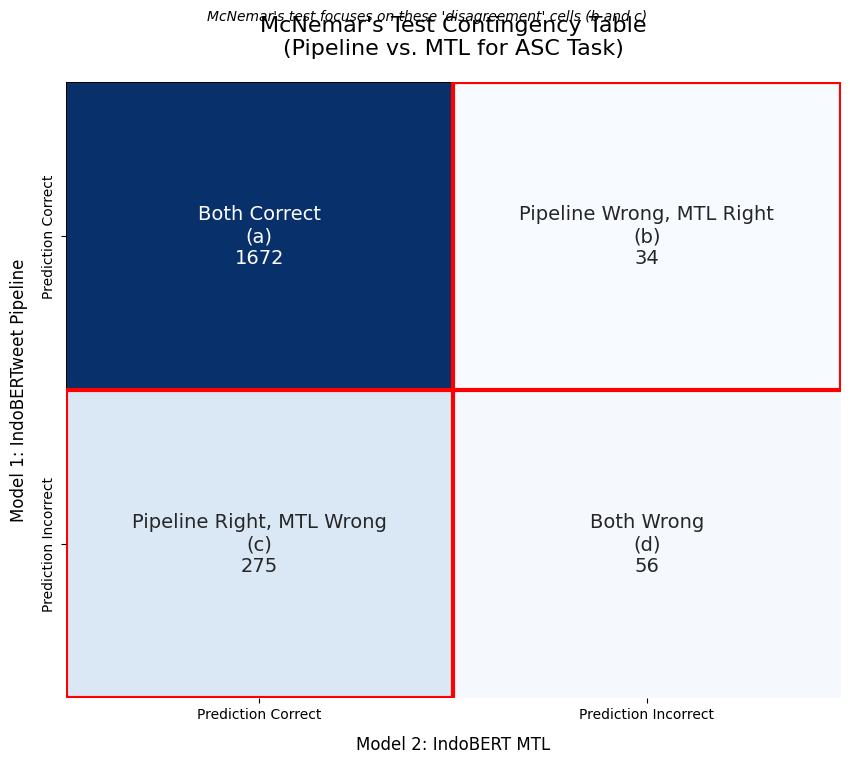

In [ ]:
# Cell to Visualize the McNemar's Test Contingency Table
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Define the data from your test results ---
# The contingency table: [[a, b], [c, d]]
# a: Both models correct
# b: Model 1 incorrect, Model 2 correct
# c: Model 1 correct, Model 2 incorrect
# d: Both models incorrect
contingency_table = np.array([[1672, 34],
                              [275, 56]])

# --- 2. Create labels for each cell to explain the values ---
# This will make the plot much easier to understand.
labels = np.asarray([
    f"Both Correct\n(a)\n{contingency_table[0,0]}",
    f"Pipeline Wrong, MTL Right\n(b)\n{contingency_table[0,1]}",
    f"Pipeline Right, MTL Wrong\n(c)\n{contingency_table[1,0]}",
    f"Both Wrong\n(d)\n{contingency_table[1,1]}"
]).reshape(2,2)

# --- 3. Plot the heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=labels, fmt='', cmap='Blues',
            linewidths=.5, linecolor='black', cbar=False,
            annot_kws={"size": 14, "va": "center"})

# --- 4. Add titles and labels for clarity ---
plt.title("McNemar's Test Contingency Table\n(Pipeline vs. MTL for ASC Task)", fontsize=16, pad=20)
plt.ylabel("Model 1: IndoBERTweet Pipeline", fontsize=12, labelpad=10)
plt.xlabel("Model 2: IndoBERT MTL", fontsize=12, labelpad=10)
plt.xticks([0.5, 1.5], ['Prediction Correct', 'Prediction Incorrect'], rotation=0)
plt.yticks([0.5, 1.5], ['Prediction Correct', 'Prediction Incorrect'], rotation=90, va='center')

# Highlight the important cells for the test
plt.gca().add_patch(plt.Rectangle((0, 1), 1, 1, fill=False, edgecolor='red', lw=3))
plt.gca().add_patch(plt.Rectangle((1, 0), 1, 1, fill=False, edgecolor='red', lw=3))
plt.text(1.5, -0.2, "McNemar's test focuses on these 'disagreement' cells (b and c)",
         ha='right', fontsize=10, style='italic')

plt.show()